In [1]:
import os

measuring_root = "/Users/jesse/Thesis/Code"
execfile(os.path.join(measuring_root, "analysis/scripts/setup_analysis.py"))
import analysis.lib.purification.purify_delayfb as pu_delayfb;reload(pu_delayfb)
%matplotlib inline

Loading config for Jesse's MacBook
Loading config for Jesse's MacBook
Loading config for Jesse's MacBook
reloaded
Loading config for Jesse's MacBook
Loading config for Jesse's MacBook
Loading config for Jesse's MacBook
Setting up analysis environment for Jesse's MacBook
reloaded
Loading config for Jesse's MacBook
reloaded
Loading config for Jesse's MacBook


reloaded
Loading config for Jesse's MacBook


/Users/jesse/Thesis/Code/analysis/lib/math/error.py:70: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if uncertainties == None:
/Users/jesse/Thesis/Code/analysis/lib/fitting/fit.py:99: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if not success or cov == None: # FIXME: find a better solution!!!
/Users/jesse/Thesis/Code/analysis/lib/tools/plot.py:40: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if fit_xvals == None:


Converged with chi squared  0.0143449437428
degrees of freedom, dof  10
RMS of residuals (i.e. sqrt(chisq/dof))  0.0378747194615
Reduced chisq (i.e. variance of residuals)  0.00143449437428

fitted parameters at minimum, with 68% C.I.:
 0 f              0.017079 +/-   0.000398
 1 A              0.459055 +/-   0.039107
 2 phi            2.342839 +/-   4.355718
 3 t            155.707148 +/-  60.066687

correlation matrix:
               f         A         phi       t         
         f  1.000000
         A -0.197282  1.000000
       phi -0.866651  0.297884  1.000000
         t  0.068922 -0.878346 -0.196643  1.000000

This is the phase detuning 6.0
Acquired phase per repetition (compensating for phase_detuning=) 0.149 +/- 0.143
phase offset  2.343


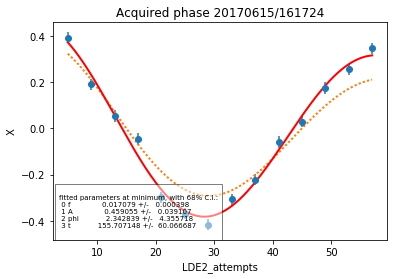

Converged with chi squared  0.00695318301101
degrees of freedom, dof  10
RMS of residuals (i.e. sqrt(chisq/dof))  0.0263688888863
Reduced chisq (i.e. variance of residuals)  0.000695318301101

fitted parameters at minimum, with 68% C.I.:
 0 f              0.017099 +/-   0.000266
 1 A              0.440289 +/-   0.024662
 2 phi           -6.007017 +/-   3.127311
 3 t            279.773512 +/- 127.012858

correlation matrix:
               f         A         phi       t         
         f  1.000000
         A -0.182601  1.000000
       phi -0.882222  0.284449  1.000000
         t  0.038008 -0.874300 -0.169179  1.000000

This is the phase detuning 6.0
Acquired phase per repetition (compensating for phase_detuning=) 0.156 +/- 0.096
phase offset  -6.007


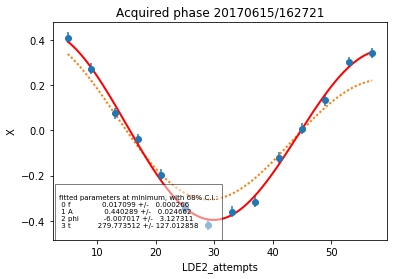

Converged with chi squared  0.0418728704023
degrees of freedom, dof  10
RMS of residuals (i.e. sqrt(chisq/dof))  0.064709250036
Reduced chisq (i.e. variance of residuals)  0.00418728704023

fitted parameters at minimum, with 68% C.I.:
 0 f              0.016394 +/-   0.000719
 1 A              0.389751 +/-   0.064865
 2 phi           -0.648377 +/-   8.489479
 3 t            211.135038 +/- 221.796506

correlation matrix:
               f         A         phi       t         
         f  1.000000
         A -0.181136  1.000000
       phi -0.872005  0.293451  1.000000
         t  0.045764 -0.878846 -0.185969  1.000000

This is the phase detuning 6.0
Acquired phase per repetition (compensating for phase_detuning=) -0.098 +/- 0.259
phase offset  -0.648


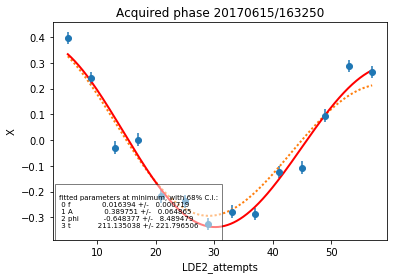

In [2]:
reload(pu_delayfb)

N_sweep_msmts_ots = {
    'N2': '20170615161800',
    'N4': '20170615162800',
    'N6': '20170615163300'
}

Ns = np.array([2, 4, 6])

det_sweep_x = []
det_sweep_y = []
det_sweep_y_u = []
det_sweep_fr = []

for N in Ns:
    sfr, sx, sy, sy_u = pu_delayfb.calibrate_LDE_phase(contains = 'phase_fb_delayline',
                                older_than = N_sweep_msmts_ots['N%d' % N],
                                do_fit = True,fixed = [1],show_guess = True, plot_fit=False, 
                                freq = 6/360.,decay = 100,phi0=0.0, ret_fit_data=True
                                #offset=0.5, A0 = 0.4
                               )
    det_sweep_x.append(sx)
    det_sweep_y.append(sy)
    det_sweep_y_u.append(sy_u)
    det_sweep_fr.append(sfr)

reloaded
Loading config for Jesse's MacBook


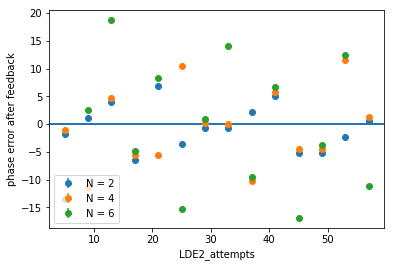

In [5]:
reload(pu_delayfb)

fig = plt.figure()
ax = plt.subplot(111)

xN2, yN2, _ = pu_delayfb.analyse_delay_feedback_phase_error('fb_delayline', older_than=N_sweep_msmts_ots['N2'], name='X_positive', label='N = 2', ret_data=True)
xN4, yN4, _ = pu_delayfb.analyse_delay_feedback_phase_error('fb_delayline', older_than=N_sweep_msmts_ots['N4'], name='X_positive', label='N = 4', ret_data=True)
xN6, yN6, _ = pu_delayfb.analyse_delay_feedback_phase_error('fb_delayline', older_than=N_sweep_msmts_ots['N6'], name='X_positive', label='N = 6', ret_data=True)

plt.legend(loc=3)

plt.savefig("phase_error_spread_LDE2_attempts.png", dpi=300)

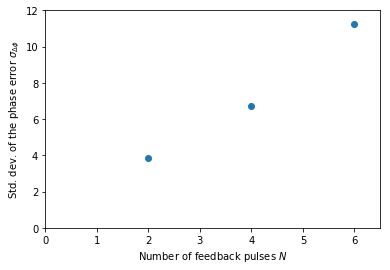

In [6]:
phase_error_mean = np.zeros((3))
phase_error_std = np.zeros((3))

phase_error_arrays = [yN2, yN4, yN6]

for i, arr in enumerate(phase_error_arrays):
    phase_error_mean[i] = np.mean(arr)
    phase_error_std[i] = np.std(arr)
    
plt.figure()
# plt.scatter(Ns, phase_error_mean, label='mean')
plt.scatter(Ns, phase_error_std, label='std dev')
plt.xlim(0,6.5)
plt.ylim(0,12)

plt.xlabel(r"Number of feedback pulses $N$")
plt.ylabel(r"Std. dev. of the phase error $\sigma_{\Delta\phi}$")

plt.savefig("std_dev_phase_error_delay_N.png", dpi=300)

In [7]:
def fit_decaying_cos_with_phase_errors(g_f, g_a, g_A, g_phi,g_t,phase_errors):
    fitfunc_str = 'A *exp(-x/t) cos(2pi * (f*x + (phi + phi_err/360) ) + a'

    f = fit.Parameter(g_f, 'f')
    a = fit.Parameter(g_a, 'a')
    A = fit.Parameter(g_A, 'A')
    phi = fit.Parameter(g_phi, 'phi')
    t   = fit.Parameter(g_t, 't')
    # print 'guessed frequency is '+str(g_f)
    p0 = [f, a, A,phi,t]

    def fitfunc(x):
        return a() + A()*np.exp(-x/t()) * np.cos(2*np.pi*( f()*x + (phi()+phase_errors)/360.))

    return p0, fitfunc, fitfunc_str

def plot_func_decaying_cos_with_phase_errors(x, p0, phase_errors):
    f, a, A,phi,t = p0
    
    return a + A*np.exp(-x/t) * np.cos(2*np.pi*( f*x + (phi+phase_errors)/360.))

reloaded
Loading config for Jesse's MacBook


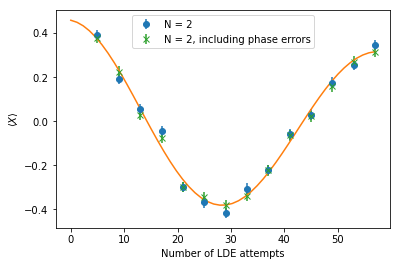

In [9]:
reload(pu_delayfb)

i = 0
N = Ns[i]

sx, sy, sy_u, sfr = det_sweep_x[i], det_sweep_y[i], det_sweep_y_u[i], det_sweep_fr[i]

fig = plt.figure()
ax = plt.subplot(111)
plt.xlabel("Number of LDE attempts")
plt.ylabel(r"$\langle X \rangle$")

xvals = np.linspace(0, np.max(sx))

color = plt.errorbar(sx, sy, sy_u, fmt='o', label="N = %d" % N)[0].get_color()

plt.plot(xvals, sfr['fitfunc'](xvals))
fit_plus_phase_errors = np.zeros_like(phase_error_arrays[i])

old_phi = sfr['params_dict']['phi']
phi_idx = 2

for j, phase_err in enumerate(phase_error_arrays[i]):
    sfr['p0'][phi_idx].set(old_phi + phase_err)
    fit_plus_phase_errors[j] = sfr['fitfunc'](sx[j])
sfr['p0'][phi_idx].set(old_phi)
plt.errorbar(sx, fit_plus_phase_errors, sy_u, fmt='x', label="N = %d, including phase errors" % N)

plt.legend()

plt.savefig("detuning_sweep_normal_fit_with_phase_errors_N_%d.png" % N, dpi=300)

reloaded
Loading config for Jesse's MacBook
Converged with chi squared  0.00640977120948
degrees of freedom, dof  10
RMS of residuals (i.e. sqrt(chisq/dof))  0.0253175259642
Reduced chisq (i.e. variance of residuals)  0.000640977120948

fitted parameters at minimum, with 68% C.I.:
 0 f              0.017220 +/-   0.000260
 1 A              0.452368 +/-   0.025281
 2 phi            0.990876 +/-   2.913223
 3 t            180.452003 +/-  52.946468

correlation matrix:
               f         A         phi       t         
         f  1.000000
         A -0.191286  1.000000
       phi -0.872505  0.281294  1.000000
         t  0.068482 -0.875718 -0.185038  1.000000



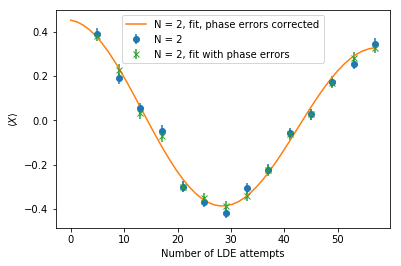

In [13]:
reload(pu_delayfb)

i = 0
N = Ns[i]

sx, sy, sy_u = det_sweep_x[i], det_sweep_y[i], det_sweep_y_u[i]



freq = 6.0/360.0
phi0 = 0.0
decay = 100.0
offset = 0.0
A0 = 0.5

fixed = [1]

p0, fitfunc, fitfunc_str = fit_decaying_cos_with_phase_errors(freq,offset,A0,phi0,decay, phase_errors=phase_error_arrays[i])
sfr = fit.fit1d(sx, sy,None,p0=p0, fitfunc=fitfunc, do_print=True, ret=True, VERBOSE=True, fixed=fixed)


fig = plt.figure()
ax = plt.subplot(111)
plt.xlabel("Number of LDE attempts")
plt.ylabel(r"$\langle X \rangle$")



xvals = np.linspace(0, np.max(sx))

color = plt.errorbar(sx, sy, sy_u, fmt='o', label="N = %d" % N)[0].get_color()

params_dict = sfr['params_dict']
p0 = [params_dict['f'], offset, params_dict['A'], params_dict['phi'], params_dict['t']]

plotfunc = lambda x: plot_func_decaying_cos_with_phase_errors(x, p0, 0.0)

plt.plot(xvals, plotfunc(xvals), label="N = %d, fit, phase errors corrected" % N)
fit_plus_phase_errors = np.zeros_like(phase_error_arrays[i])

fit_plus_phase_errors = plot_func_decaying_cos_with_phase_errors(sx, p0, phase_errors=phase_error_arrays[i])

plt.errorbar(sx, fit_plus_phase_errors, sy_u, fmt='x', label="N = %d, fit with phase errors" % N)

plt.legend()

plt.savefig("detuning_sweep_phase_error_fit_N_%d.png" % N, dpi=300)